In [1]:
# import geography_based_batched
# import geography_based
from datasets import *
import torch.utils.data as data
import torchvision.transforms as transforms
import time

In [2]:
import numpy as np
import pickle
import fasttext
from collections import Counter
import re
from countryinfo import CountryInfo
import torchvision.transforms as transforms
from torchvision import models
import torch.utils.data # changed to prevent namespace pollution
import torch.nn.functional as F
import torch.nn as nn
import torch
import pycountry
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

## initialize YFCC dataset to test batching 

In [3]:
transform_train = transforms.Compose([           
        transforms.ToTensor(),                          
        ])

dataset = YfccPlacesDataset(transform_train, 10, num_data_alex = 2000)

dataloader = data.DataLoader(dataset=dataset, 
              num_workers=0,
              batch_size=1,
              collate_fn=collate_fn)

subsetting first 2000!


## Define batched version of count_langs

In [ ]:
def count_langs_batch(dataloader, batch_size = 64):
    print("batch method, batch size: {0}".format(batch_size))
    mappings = pickle.load(open('country_lang_mappings.pkl', 'rb'))
    iso3_to_lang = mappings['iso3_to_lang']
    # Country to iso3 mappings that are missing
    missing = {'South+Korea': 'KOR',
            'North+Korea': 'PRK',
            'Laos': 'LAO',
            'Caribbean+Netherlands': 'BES',
            'St.+Lucia': 'LCA',
            'East+Timor': 'TLS',
            'Democratic+Republic+of+Congo': 'COD',
            'Swaziland': 'SWZ',
            'Cape+Verde': 'CPV',
            'C%C3%B4te+d%C2%B4Ivoire': 'CIV',
            'Ivory+Coast': 'CIV',
            'Channel+Islands': 'GBR'
            }


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = models.alexnet(pretrained=True).to(device)
    new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    model.classifier = new_classifier
    
    model.eval() # IMPORANT: turn off all model stochasticity for comparison

    with_country = dataloader.dataset.with_country

    country_with_langs = {}
    country_with_imgs = {} # for each country, first list is tourist second is local
    lang_counts = {}
    
    # arrays to cache data for batching speedup
    batched_big_data =[]
    batched_country_data=[]
    batched_local_lang_data=[]
    batched_target_data=[]
    
    
    num_data = len(dataloader)

    detecter = fasttext.load_model('lid.176.bin')
    lang_dict = {}
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    for i, (data, target) in enumerate(tqdm(dataloader)):
        if data is None:
            continue
        this_tags = [tag['label'] for tag in target[0] if len(tag['label']) >= 3]
        if len(this_tags) > 0:
            srcz = []
            conf = []
            for tag in this_tags:
                classify = detecter.predict(tag)
                srcz.append(classify[0][0][9:])
                conf.append(classify[1][0])

            # Pick out the most common language
            commons = Counter(srcz).most_common()
            the_src = commons[0][0]
            # If the most common language is English, look at the second most common language
            # since people oftentimes use English even when it's not their native language
            if the_src == 'en' and len(commons) > 1:
                the_src_maybe = commons[1][0]
                words = [i for i in range(len(srcz)) if srcz[i] == the_src_maybe]
                # If this second most common language has been classified with more than .5
                # probability, then choose this language for the image
                for word in words:
                    if conf[word] > .5: 
                        the_src = the_src_maybe
            if the_src in lang_counts.keys():
                lang_counts[the_src] += 1
            else:
                lang_counts[the_src] = 1

            country = target[2][0]
            iso3 = None
            local = None
            try:
                iso3 = pycountry.countries.search_fuzzy(country.replace('+', ' '))[0].alpha_3
            except LookupError:
                iso3 = missing[country]
            try:
                country_info = CountryInfo(country.replace('+', ' ')).info()
            except KeyError:
                country_info = {}
            country_name = country.split('+')
            if 'name' in country_info.keys():
                country_name += country_info['name']
            if 'nativeName' in country_info.keys():
                country_name += country_info['nativeName']

            # When comparing images to distinguish between tourist and local, we further look into the content of the tags,
            # allowing some images to be categorized as 'unknown' if we are not that sure if it's tourist or local

            # Local: in a local language, country's name isn't a tag, and 'travel' isn't a tag
            # Tourist: in a non-local language, or 'travel' is a tag
            try:
                if the_src in iso3_to_lang[iso3] and len(set(country_name)&set(this_tags)) == 0 and 'travel' not in this_tags:
                    local = 1
                elif the_src not in iso3_to_lang[iso3] or 'travel' in this_tags:
                    local = 0
            except KeyError:
                 print("This iso3 can't be found in iso3_to_lang: {}".format(iso3))

            if country not in country_with_langs.keys():
                country_with_langs[country] = []
                country_with_imgs[country] = [[], []]
            country_with_langs[country].append(the_src)

            if local is not None:
                if len(country_with_imgs[country][local]) < 500:
                    data = normalize(data).to(device)
                    big_data = F.interpolate(data.unsqueeze(0), size=224, mode='bilinear').to(device)
                    # cache these results for speedup 
                    batched_big_data.append(big_data)
                    batched_country_data.append(country)
                    batched_local_lang_data.append(local)
                    batched_target_data.append(target[3])
                    
                    # run model on batched data
                    if i % batch_size == 0 or i == num_data-1:
                        all_big_data = torch.cat(batched_big_data, 0)
                        batched_features = model.forward(all_big_data)
                        for i, cur_feature in enumerate(batched_features):
                            cur_country = batched_country_data[i]
                            cur_local = batched_local_lang_data[i]
                            cur_target = batched_target_data[i]
                            country_with_imgs[cur_country][cur_local].append((cur_feature.data.cpu().numpy(), cur_target))

                        batched_big_data =[]
                        batched_country_data=[]
                        batched_local_lang_data=[]
                        batched_target_data=[]


    info = {}
    info['lang_counts'] = lang_counts
    info['country_with_langs'] = country_with_langs
    info['country_with_imgs'] = country_with_imgs
    

    pickle.dump(info, open("results/testing/batched_10.pkl", "wb"))
    return info

## Define Old (unbatched) version of count_langs()

In [ ]:
def count_langs_old(dataloader):
    mappings = pickle.load(open('country_lang_mappings.pkl', 'rb'))
    iso3_to_lang = mappings['iso3_to_lang']
    # Country to iso3 mappings that are missing
    missing = {'South+Korea': 'KOR',
            'North+Korea': 'PRK',
            'Laos': 'LAO',
            'Caribbean+Netherlands': 'BES',
            'St.+Lucia': 'LCA',
            'East+Timor': 'TLS',
            'Democratic+Republic+of+Congo': 'COD',
            'Swaziland': 'SWZ',
            'Cape+Verde': 'CPV',
            'C%C3%B4te+d%C2%B4Ivoire': 'CIV',
            'Ivory+Coast': 'CIV',
            'Channel+Islands': 'GBR'
            }


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = models.alexnet(pretrained=True).to(device)
    new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    model.classifier = new_classifier
    model.eval() # IMPORANT: turn off all model stochasticity for comparison

    with_country = dataloader.dataset.with_country

    country_with_langs = {}
    country_with_imgs = {} # for each country, first list is tourist second is local
    lang_counts = {}

    detecter = fasttext.load_model('lid.176.bin')
    lang_dict = {}
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    for i, (data, target) in enumerate(tqdm(dataloader)):
        if data is None:
            continue
        this_tags = [tag['label'] for tag in target[0] if len(tag['label']) >= 3]
        if len(this_tags) > 0:
            srcz = []
            conf = []
            for tag in this_tags:
                classify = detecter.predict(tag)
                srcz.append(classify[0][0][9:])
                conf.append(classify[1][0])

            # Pick out the most common language
            commons = Counter(srcz).most_common()
            the_src = commons[0][0]
            # If the most common language is English, look at the second most common language
            # since people oftentimes use English even when it's not their native language
            if the_src == 'en' and len(commons) > 1:
                the_src_maybe = commons[1][0]
                words = [i for i in range(len(srcz)) if srcz[i] == the_src_maybe]
                # If this second most common language has been classified with more than .5
                # probability, then choose this language for the image
                for word in words:
                    if conf[word] > .5: 
                        the_src = the_src_maybe
            if the_src in lang_counts.keys():
                lang_counts[the_src] += 1
            else:
                lang_counts[the_src] = 1

            country = target[2][0]
            iso3 = None
            local = None
            try:
                iso3 = pycountry.countries.search_fuzzy(country.replace('+', ' '))[0].alpha_3
            except LookupError:
                iso3 = missing[country]
            try:
                country_info = CountryInfo(country.replace('+', ' ')).info()
            except KeyError:
                country_info = {}
            country_name = country.split('+')
            if 'name' in country_info.keys():
                country_name += country_info['name']
            if 'nativeName' in country_info.keys():
                country_name += country_info['nativeName']

            # When comparing images to distinguish between tourist and local, we further look into the content of the tags,
            # allowing some images to be categorized as 'unknown' if we are not that sure if it's tourist or local

            # Local: in a local language, country's name isn't a tag, and 'travel' isn't a tag
            # Tourist: in a non-local language, or 'travel' is a tag
            try:
                if the_src in iso3_to_lang[iso3] and len(set(country_name)&set(this_tags)) == 0 and 'travel' not in this_tags:
                    local = 1
                elif the_src not in iso3_to_lang[iso3] or 'travel' in this_tags:
                    local = 0
            except KeyError:
                 print("This iso3 can't be found in iso3_to_lang: {}".format(iso3))

            if country not in country_with_langs.keys():
                country_with_langs[country] = []
                country_with_imgs[country] = [[], []]
            country_with_langs[country].append(the_src)
            if local is not None:
                if len(country_with_imgs[country][local]) < 500:
                    data = normalize(data).to(device)
                    big_data = F.interpolate(data.unsqueeze(0), size=224, mode='bilinear').to(device)
                    this_features = model.forward(big_data)
                    country_with_imgs[country][local].append((this_features.data.cpu().numpy(), target[3]))


    info = {}
    info['lang_counts'] = lang_counts
    info['country_with_langs'] = country_with_langs
    info['country_with_imgs'] = country_with_imgs
    pickle.dump(info, open("results/testing/old_10.pkl", "wb"))
    return info
    
#     pickle.dump(info, open("results/{}/10.pkl".format(args.folder), "wb"))




## Test for correctness

In [ ]:
old_res = count_langs_old(dataloader)
batched_res = count_langs_batch(dataloader) # default batch size is 64


# old_res = old_res[0]
# batched_res = batched_res[0]

## Check if keys match

In [ ]:
print("Do keys match? {0}".format(old_res.keys() == batched_res.keys()))

In [ ]:
old_res.keys()

## Check if 'lang_counts' match

In [ ]:
old_res['lang_counts'] == batched_res['lang_counts']

## Check if 'country_with_langs' match

In [ ]:
old_res['country_with_langs'] == batched_res['country_with_langs']

## Check if country_with_images same with 0.01 element-wise tolerance:

In [ ]:
old_sum, new_sum = 0,0
for country in old_res['country_with_imgs']:
# for country in ['Japan']:
    for local in range(2):
        num_img_old = len(old_res['country_with_imgs'][country][local])
        num_img_new = len(batched_res['country_with_imgs'][country][local])
        num_images_match = num_img_old == num_img_new
        if not num_images_match:
            print("NUM IMAGES DONT MATCH")
        
        for i in range(num_img_new):
            # check if filepath is same
            filepath_comp = old_res['country_with_imgs'][country][local][i][1] == batched_res['country_with_imgs'][country][local][i][1] 
            if not filepath_comp:
                print("FILEPATHS DONT MATCH")
                
            # check if feature array is elementwise same with 0.01 tolerance 
            old_feat = old_res['country_with_imgs'][country][local][i][0]
            new_feat = batched_res['country_with_imgs'][country][local][i][0]
            
            allclose = np.allclose(old_feat, new_feat, atol = 0.01)
            if not allclose:
                print("Over threshold!")
#             print("element wise comparison thresh  = 0.01: {0}".format(allclose))
            
#             print(np.sum(old_feat), np.sum(new_feat))
            old_sum += np.sum(old_feat)
            new_sum += np.sum(new_feat)
            
    print("old: sum of all img feature vecs for {0}: {1}".format(country, old_sum))
    print("batched: sum of all img feature vecs for {0}: {1}".format(country, new_sum))
    # check if sum of all feature elements is within 0.5 of each other
    if np.abs(old_sum - new_sum) > 0.5:
        print("difference in sum of feature vecs greater than 0.5")
    print("================================")

print("done")

# Timing Test

the bottleneck is with text classification (which takes 99% time per iteration), so to show efficacy of batch operation on model() call, we provide dummy data to remove classification overhead

## Define batched version of function without classification overhead

In [ ]:
def count_langs_batch_time(dataloader, batch_size = 64):
    print("batch method, batch size: {0}".format(batch_size))


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = models.alexnet(pretrained=True).to(device)
    new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    model.classifier = new_classifier
    
    model.eval() # IMPORANT: turn off all model stochasticity for comparison


    country_with_langs = {}
    country_with_imgs = {} # for each country, first list is tourist second is local
    lang_counts = {}
    
    # arrays to cache data for batching speedup
    batched_big_data =[]
    batched_country_data=[]
    batched_local_lang_data=[]
    batched_target_data=[]
    
    
    num_data = len(dataloader)

    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    for i, (data, target) in enumerate(tqdm(dataloader)):
        if data is None:
            continue
            
        country = "dummy_country"
        local = 1
        target = ["dummy", "dummy", "dummy", "dummy"]

        the_src = "en"
        if country not in country_with_langs.keys():
            country_with_langs[country] = []
            country_with_imgs[country] = [[], []]

        country_with_langs[country].append(the_src)



        if local is not None:
            if len(country_with_imgs[country][local]) < 500:
                data = normalize(data).to(device)
                big_data = F.interpolate(data.unsqueeze(0), size=224, mode='bilinear').to(device)
                # cache these results for speedup 
                batched_big_data.append(big_data)
                batched_country_data.append(country)
                batched_local_lang_data.append(local)
                batched_target_data.append(target[3])

                # run model on batched data
                if i % batch_size == 0 or i == num_data-1:
                    all_big_data = torch.cat(batched_big_data, 0)
                    batched_features = model.forward(all_big_data)
                    for i, cur_feature in enumerate(batched_features):
                        cur_country = batched_country_data[i]
                        cur_local = batched_local_lang_data[i]
                        cur_target = batched_target_data[i]
                        country_with_imgs[cur_country][cur_local].append((cur_feature.data.cpu().numpy(), cur_target))

                    batched_big_data =[]
                    batched_country_data=[]
                    batched_local_lang_data=[]
                    batched_target_data=[]


    info = {}
    info['lang_counts'] = lang_counts
    info['country_with_langs'] = country_with_langs
    info['country_with_imgs'] = country_with_imgs
    
    return info

## Define old version of function without classification overhead

In [ ]:
def count_langs_old_time(dataloader):
    print("old method")
    

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = models.alexnet(pretrained=True).to(device)
    new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    model.classifier = new_classifier
    
    model.eval() # IMPORANT: turn off all model stochasticity for comparison

    
    
    num_data = len(dataloader)
    country_with_langs = {}
    country_with_imgs = {} # for each country, first list is tourist second is local
    lang_counts = {}
    

    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    for i, (data, target) in enumerate(tqdm(dataloader)):
        if data is None:
            continue
            
        country = "dummy_country"
        local = 1
        target = ["dummy", "dummy", "dummy", "dummy"]

        the_src = "en"
        if country not in country_with_langs.keys():
            country_with_langs[country] = []
            country_with_imgs[country] = [[], []]

        country_with_langs[country].append(the_src)



        if local is not None:
            if len(country_with_imgs[country][local]) < 500:
                data = normalize(data).to(device)
                big_data = F.interpolate(data.unsqueeze(0), size=224, mode='bilinear').to(device)
                feature = model.forward(big_data)
                country_with_imgs[country][local].append((feature.data.cpu().numpy(), target[3]))



    info = {}
    info['lang_counts'] = lang_counts
    info['country_with_langs'] = country_with_langs
    info['country_with_imgs'] = country_with_imgs
    
    return info

# Compare times

In [ ]:
old_time = []
batch_time = []

old_res = []
batched_res = []

for _ in range(3):
    start = time.time()
    old_res.append(count_langs_old_time(dataloader))
    end = time.time()
    old_time.append(end-start)
    
    start = time.time()
    batched_res.append(count_langs_batch_time(dataloader))
    end = time.time()
    batch_time.append(end-start)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print("old method avg time: {0}".format(np.mean(old_time)))
print("batched method avg time: {0}".format(np.mean(batch_time)))

## Timing of model.forward depending on batch size

In [21]:
def get_batch(dataloader, batch_size = 64):
    '''
    The goal of this function is to return a batch
    of size batch_size as a torch tensor 
    of shape (batch_size, 3,3,224)
    '''
    print("batch method, batch size: {0}".format(batch_size))


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = models.alexnet(pretrained=True).to(device)
    new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    model.classifier = new_classifier
    
    model.eval() # IMPORANT: turn off all model stochasticity for comparison


    # arrays to cache data for batching
    batched_big_data =[]

    
    num_data = len(dataloader)

    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    for i, (data, target) in enumerate(tqdm(dataloader)):
        if data is None:
            continue
            
        # early exit and return the batch
        if i == batch_size:
            print("batch obtained of size {0} obtained, returning".format(batch_size))
            all_big_data = torch.cat(batched_big_data, 0)
            return all_big_data
            

        data = normalize(data).to(device)
        big_data = F.interpolate(data.unsqueeze(0), size=224, mode='bilinear').to(device)
        # cache these results
        batched_big_data.append(big_data)

        

def timing_test(batch_data):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = models.alexnet(pretrained=True).to(device)
    new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    model.classifier = new_classifier
    model.eval() # IMPORANT: turn off all model stochasticity for comparison
    
    time_arr = []
    for _ in tqdm(range(1000)):
        start = time.time()
        #================================
        feature = model.forward(batch_dat)
        #================================
        end = time.time()
        time_arr.append(end-start)
    return np.mean(time_arr)

In [30]:
forward_time = []
batch_sizes = [100, 200, 300, 400]
for i in batch_sizes:
    batch_dat = get_batch(dataloader, i)
    print("beginning timing test, averaging over 1k executions of model.forward()")
    avg_execution_time = timing_test(batch_dat)
    
    forward_time.append(avg_execution_time)
    print(forward_time)
    print("================================")

batch method, batch size: 100


  0%|          | 0/2000 [00:00<?, ?it/s]/n/fs/revise-scr/alex/miniconda2/envs/toolenv/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
  5%|▌         | 100/2000 [00:02<00:40, 47.08it/s]


batch obtained of size 100 obtained, returning
beginning timing test, averaging over 1k executions of model.forward()


100%|██████████| 1000/1000 [00:17<00:00, 56.32it/s]


[0.017628787755966185]
batch method, batch size: 200


 10%|█         | 200/2000 [00:10<01:30, 19.84it/s]


batch obtained of size 200 obtained, returning
beginning timing test, averaging over 1k executions of model.forward()


100%|██████████| 1000/1000 [00:27<00:00, 36.03it/s]


[0.017628787755966185, 0.027569053649902343]
batch method, batch size: 300


 15%|█▌        | 300/2000 [00:11<01:07, 25.14it/s]


batch obtained of size 300 obtained, returning
beginning timing test, averaging over 1k executions of model.forward()


100%|██████████| 1000/1000 [00:36<00:00, 27.38it/s]


[0.017628787755966185, 0.027569053649902343, 0.03628393721580506]
batch method, batch size: 400


 20%|██        | 400/2000 [00:14<00:57, 27.69it/s]


batch obtained of size 400 obtained, returning
beginning timing test, averaging over 1k executions of model.forward()


100%|██████████| 1000/1000 [00:49<00:00, 20.24it/s]

[0.017628787755966185, 0.027569053649902343, 0.03628393721580506, 0.04908299827575684]


## Plot trend of batch size vs avg execution time of model.forward() call

In [31]:
# find linear fit from data
x = np.asarray(batch_sizes)

m, b = np.polyfit(x, forward_time, 1)

Text(0.5, 1.0, 'average time per model() call vs batch size')

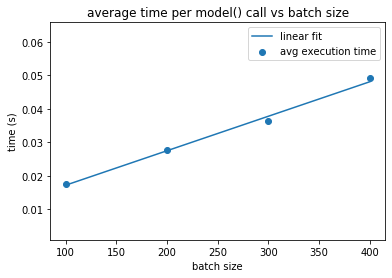

In [32]:
plt.scatter(x, forward_time, label = "avg execution time")
plt.plot(x, x*m+b, label="linear fit")
plt.xlabel("batch size")
plt.ylabel("time (s)")
plt.legend()


plt.title("average time per model() call vs batch size")